In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
!pip install linearmodels
from linearmodels import PanelOLS
import matplotlib.pyplot as plt
from linearmodels import RandomEffects
from scipy.stats.mstats import winsorize
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import statsmodels.formula.api as smf
import statsmodels.api as sm
import seaborn as sns
from linearmodels.panel import PanelOLS, RandomEffects
from linearmodels.panel import compare
from scipy.stats import chi2

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

## **Code Block 4.1:**
**Data Ingestion**

In [ ]:
chunk_size = 100000
filtered_chunks = []

for chunk in pd.read_csv("/content/Gravity_V202211.csv", chunksize=chunk_size, low_memory=False ):
    chunk_filtered = chunk[chunk["year"] >= 2000]
    filtered_chunks.append(chunk_filtered)

gravity = pd.concat(filtered_chunks, ignore_index=True)
gravity.tail()

,year,country_id_o,country_id_d,iso3_o,iso3_d,iso3num_o,iso3num_d,country_exists_o,country_exists_d,gmt_offset_2020_o,...,entry_time_o,entry_time_d,entry_tp_o,entry_tp_d,tradeflow_comtrade_o,tradeflow_comtrade_d,tradeflow_baci,manuf_tradeflow_baci,tradeflow_imf_o,tradeflow_imf_d
1397083,2017,ZWE,ZWE,ZWE,ZWE,716.0,716.0,1,1,2.0,...,61.0,61.0,70.0,70.0,NaN,NaN,NaN,NaN,NaN,NaN
1397084,2018,ZWE,ZWE,ZWE,ZWE,716.0,716.0,1,1,2.0,...,32.0,32.0,41.0,41.0,NaN,NaN,NaN,NaN,NaN,NaN
1397085,2019,ZWE,ZWE,ZWE,ZWE,716.0,716.0,1,1,2.0,...,27.0,27.0,36.0,36.0,NaN,NaN,NaN,NaN,NaN,NaN
1397086,2020,ZWE,ZWE,ZWE,ZWE,716.0,716.0,1,1,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1397087,2021,ZWE,ZWE,ZWE,ZWE,716.0,716.0,1,1,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
gravity.shape

(1397088, 87)

In [ ]:
gravity.columns

Index(['year', 'country_id_o', 'country_id_d', 'iso3_o', 'iso3_d', 'iso3num_o',
       'iso3num_d', 'country_exists_o', 'country_exists_d',
       'gmt_offset_2020_o', 'gmt_offset_2020_d', 'distw_harmonic',
       'distw_arithmetic', 'distw_harmonic_jh', 'distw_arithmetic_jh', 'dist',
       'main_city_source_o', 'main_city_source_d', 'distcap', 'contig',
       'diplo_disagreement', 'scaled_sci_2021', 'comlang_off', 'comlang_ethno',
       'comcol', 'col45', 'legal_old_o', 'legal_old_d', 'legal_new_o',
       'legal_new_d', 'comleg_pretrans', 'comleg_posttrans',
       'transition_legalchange', 'comrelig', 'heg_o', 'heg_d', 'col_dep_ever',
       'col_dep', 'col_dep_end_year', 'col_dep_end_conflict', 'empire',
       'sibling_ever', 'sibling', 'sever_year', 'sib_conflict', 'pop_o',
       'pop_d', 'gdp_o', 'gdp_d', 'gdpcap_o', 'gdpcap_d', 'pop_source_o',
       'pop_source_d', 'gdp_source_o', 'gdp_source_d', 'gdp_ppp_o',
       'gdp_ppp_d', 'gdpcap_ppp_o', 'gdpcap_ppp_d', 'pop_pwt_o',

## **Code Block 4.2:**
**Log transformation**


## **Code Bloc 4.3:**
**PPML implementation**


In [ ]:
df = gravity.copy()
# Log GDP and Distance
df['log_gdp_o'] = np.log(df['gdp_o'])
df['log_gdp_d'] = np.log(df['gdp_d'])
df['log_dist'] = np.log(df['distw_harmonic'] + 1)  # +1 to avoid log(0)
df['log_trade'] = np.log(df['tradeflow_baci'] + 1)

model = smf.poisson(
    formula='tradeflow_baci ~ log_gdp_o + log_gdp_d + log_dist + wto_o + wto_d + fta_wto + contig + comlang_off',
    data=df).fit(cov_type='HC0')
print(model.summary())

Optimization terminated successfully.
         Current function value: 218652.109640
         Iterations 16
                          Poisson Regression Results                          
Dep. Variable:         tradeflow_baci   No. Observations:               538950
Model:                        Poisson   Df Residuals:                   538941
Method:                           MLE   Df Model:                            8
Date:                Tue, 15 Apr 2025   Pseudo R-squ.:                  0.8730
Time:                        08:34:22   Log-Likelihood:            -1.1784e+11
converged:                       True   LL-Null:                   -9.2762e+11
Covariance Type:                  HC0   LLR p-value:                     0.000
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     -12.8024      0.173    -73.805      0.000     -13.142     -12.462
log_gdp_o       0.81

## **Code Bloc 4.4:**
**Check for overdispersion**

In [ ]:
print("Mean of tradeflow_baci:", df["tradeflow_baci"].mean())
print("Variance of tradeflow_baci:", df["tradeflow_baci"].var())

Mean of tradeflow_baci: 461596.04805880354
Variance of tradeflow_baci: 23490750343897.777


## **Code Block 4.5:**
**Negative Binomial model**


In [ ]:
df.loc[df.isin([np.inf, -np.inf]).any(axis=1)] = np.nan

df = df.loc[df[["tradeflow_baci", "log_gdp_o", "log_gdp_d", "log_dist", "wto_o", \
                "wto_d", "fta_wto", "contig", "comlang_off"]].notna().all(axis=1)]

nb_model = sm.GLM(df["tradeflow_baci"],
                  sm.add_constant(df[["log_gdp_o", "log_gdp_d", "log_dist", "wto_o", "wto_d",\
                                      "fta_wto", "contig", "comlang_off"]]),
                  family = sm.families.NegativeBinomial())
nb_results = nb_model.fit(cov_type = "HC0")
print(nb_results.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


                 Generalized Linear Model Regression Results                  
Dep. Variable:         tradeflow_baci   No. Observations:               538950
Model:                            GLM   Df Residuals:                   538941
Model Family:        NegativeBinomial   Df Model:                            8
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -5.9665e+06
Date:                Tue, 15 Apr 2025   Deviance:                   2.6444e+06
Time:                        08:40:17   Pearson chi2:                 8.24e+07
No. Iterations:                   100   Pseudo R-squ. (CS):             0.9980
Covariance Type:                  HC0                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -9.6894      0.149    -65.118      

## **Code Block 4.6:**
**Counterfactual analysis**

In [ ]:
# Filter out intra-national trade flows
df = df[df['iso3_o'] != df['iso3_d']].copy()

# Baseline: Real WTO Memberships
df['predicted_trade'] = model.predict(df)

# WTO Exit Simulations
# Importer WTO Exit
df_imp_cf = df.copy()
df_imp_cf['wto_d'] = 0
df['pred_trade_cf_imp'] = model.predict(df_imp_cf)
df['trade_loss_imp'] = df['predicted_trade'] - df['pred_trade_cf_imp']
df['pct_loss_imp'] = 100 * df['trade_loss_imp'] / df['predicted_trade']

# Exporter WTO Exit
df_exp_cf = df.copy()
df_exp_cf['wto_o'] = 0
df['pred_trade_cf_exp'] = model.predict(df_exp_cf)
df['trade_loss_exp'] = df['predicted_trade'] - df['pred_trade_cf_exp']
df['pct_loss_exp'] = 100 * df['trade_loss_exp'] / df['predicted_trade']

# Both WTO Exit
df_both_cf = df.copy()
df_both_cf['wto_o'] = 0
df_both_cf['wto_d'] = 0
df['pred_trade_cf_both'] = model.predict(df_both_cf)
df['trade_loss_both'] = df['predicted_trade'] - df['pred_trade_cf_both']
df['pct_loss_both'] = 100 * df['trade_loss_both'] / df['predicted_trade']

# Global WTO Exit
df_wto_exit = df.copy()
df_wto_exit['wto_o'] = 0
df_wto_exit['wto_d'] = 0
df['predicted_trade_cf_wto'] = model.predict(df_wto_exit)
df['trade_loss_wto_exit'] = df['predicted_trade'] - df['predicted_trade_cf_wto']
df['trade_loss_pct_wto_exit'] = 100 * df['trade_loss_wto_exit'] / df['predicted_trade']

# FTA Introduction Simulation
df_fta = df.copy()
df_fta['fta_wto'] = 1  # Simulate universal FTA
df['predicted_trade_cf_fta'] = model.predict(df_fta)
df['trade_gain_fta'] = df['predicted_trade_cf_fta'] - df['predicted_trade']
df['trade_gain_pct_fta'] = 100 * df['trade_gain_fta'] / df['predicted_trade']

print("WTO Exit Scenarios")
print(f"Avg Trade Loss (Importer WTO Exit): {df['trade_loss_imp'].mean():,.2f}")
print(f"Avg % Trade Loss (Importer): {df['pct_loss_imp'].mean():.2f}%")
print(f"Avg Trade Loss (Exporter WTO Exit): {df['trade_loss_exp'].mean():,.2f}")
print(f"Avg % Trade Loss (Exporter): {df['pct_loss_exp'].mean():.2f}%")
print(f"Avg Trade Loss (Both WTO Exit): {df['trade_loss_both'].mean():,.2f}")
print(f"Avg % Trade Loss (Both): {df['pct_loss_both'].mean():.2f}%")
print(f"Avg Trade Loss (Global WTO Exit): {df['trade_loss_wto_exit'].mean():,.2f}")
print(f"Avg % Trade Loss (Global WTO Exit): {df['trade_loss_pct_wto_exit'].mean():.2f}%")

print("\nFTA Scenario")
print(f"Avg Trade Gain from Universal FTA: {df['trade_gain_fta'].mean():,.2f}")
print(f"Avg % Trade Gain from Universal FTA:{df['trade_gain_pct_fta'].mean():.2f}%")

WTO Exit Scenarios
Avg Trade Loss (Importer WTO Exit): 116,157.44
Avg % Trade Loss (Importer): 19.26%
Avg Trade Loss (Exporter WTO Exit): 8,793.14
Avg % Trade Loss (Exporter): 1.48%
Avg Trade Loss (Both WTO Exit): 123,015.37
Avg % Trade Loss (Both): 20.45%
Avg Trade Loss (Global WTO Exit): 123,015.37
Avg % Trade Loss (Global WTO Exit): 20.45%

FTA Scenario
Avg Trade Gain from Universal FTA: 34,948.84
Avg % Trade Gain from Universal FTA:11.09%


## **Code Block 4.7:**
**Visual summary of counterfactual analysis**


<ipython-input-13-c2204b49dad2>:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Scenario', y='Average Trade Change', data=df, palette=['#d9534f', '#5cb85c'])
<ipython-input-13-c2204b49dad2>:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Scenario', y='Average % Change', data=df, palette=['#d9534f', '#5cb85c'])


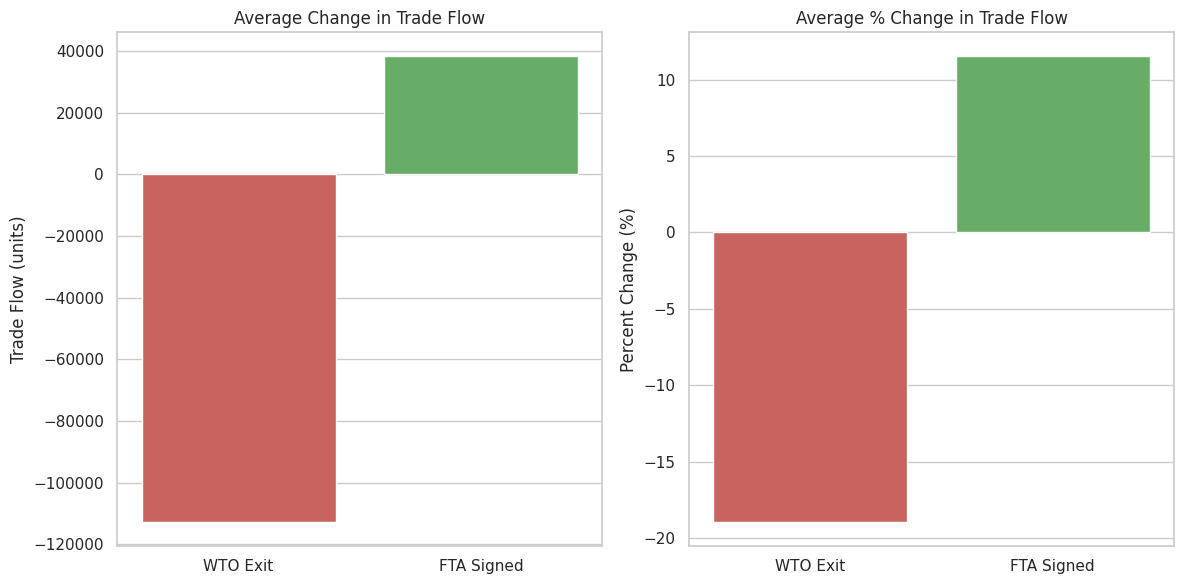

In [ ]:
scenarios = ['WTO Exit', 'FTA Signed']
avg_trade_change = [-112938.22, 38433.95]
avg_percent_change = [-18.99, 11.56]

df = pd.DataFrame({
    'Scenario': scenarios,
    'Average Trade Change': avg_trade_change,
    'Average % Change': avg_percent_change})

sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))

# Barplot for absolute trade change
plt.subplot(1, 2, 1)
sns.barplot(x='Scenario', y='Average Trade Change', data=df, palette=['#d9534f', '#5cb85c'])
plt.title('Average Change in Trade Flow')
plt.ylabel('Trade Flow (units)')
plt.xlabel('')

# Barplot for % trade change
plt.subplot(1, 2, 2)
sns.barplot(x='Scenario', y='Average % Change', data=df, palette=['#d9534f', '#5cb85c'])
plt.title('Average % Change in Trade Flow')
plt.ylabel('Percent Change (%)')
plt.xlabel('')

plt.tight_layout()
plt.show()

## **Code Block 48:**
**Panel OLS implementation**


In [ ]:
df_agg = gravity.groupby(['year', 'iso3_o']).agg({
    'tradeflow_baci': 'sum',
    'gdp_o': 'mean',
    'pop_o': 'mean'}).reset_index()

df_agg['log_tradeflow'] = (df_agg['tradeflow_baci'] + 1).apply(np.log)
df_agg['log_gdp'] = (df_agg['gdp_o'] + 1).apply(np.log)
df_agg['log_pop'] = (df_agg['pop_o'] + 1).apply(np.log)

df_agg = df_agg.rename(columns={'iso3_o': 'country'})

In [ ]:
df_agg_panel = df_agg.set_index(['country', 'year'])

panel_model = PanelOLS.from_formula(
    'log_gdp ~ log_tradeflow + log_pop + EntityEffects + TimeEffects',
    data=df_agg_panel)
panel_results = panel_model.fit(cov_type='clustered', cluster_entity=True)

print(panel_results.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:                log_gdp   R-squared:                        0.1476
Estimator:                   PanelOLS   R-squared (Between):              0.6794
No. Observations:                4313   R-squared (Within):              -0.0252
Date:                Tue, Apr 15 2025   R-squared (Overall):              0.6838
Time:                        10:04:09   Log-likelihood                    400.22
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      353.14
Entities:                         211   P-value                           0.0000
Avg Obs:                       20.441   Distribution:                  F(2,4079)
Min Obs:                       2.0000                                           
Max Obs:                       22.000   F-statistic (robust):             36.254
                            

/usr/local/lib/python3.11/dist-packages/linearmodels/panel/model.py:1260: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


## **Code Block 4.9:**
**Model comparison**


In [ ]:
df_agg_panel = df_agg.set_index(['country', 'year'])

# FE Model
model_fe = PanelOLS.from_formula(
    'log_gdp ~ log_tradeflow + log_pop + EntityEffects + TimeEffects',
    data=df_agg_panel)
results_fe = model_fe.fit(cov_type='clustered', cluster_entity=True)

# RE Model
model_re = RandomEffects.from_formula(
    'log_gdp ~ log_tradeflow + log_pop',
    data=df_agg_panel)
results_re = model_re.fit(cov_type='clustered', cluster_entity=True)

# Hausman Test via model comparison
comparison = compare({'Fixed Effects': results_fe, 'Random Effects': results_re})
print(comparison)


/usr/local/lib/python3.11/dist-packages/linearmodels/panel/model.py:1260: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)
/usr/local/lib/python3.11/dist-packages/linearmodels/panel/model.py:2759: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


                    Model Comparison                   
                        Fixed Effects    Random Effects
-------------------------------------------------------
Dep. Variable                 log_gdp           log_gdp
Estimator                    PanelOLS     RandomEffects
No. Observations                 4313              4313
Cov. Est.                   Clustered         Clustered
R-squared                      0.1476            0.7671
R-Squared (Within)            -0.0252            0.4493
R-Squared (Between)            0.6794            0.9631
R-Squared (Overall)            0.6838            0.9661
F-statistic                    353.14            7097.8
P-value (F-stat)               0.0000            0.0000
=====================     ===========   ===============
log_tradeflow                  0.0703           -0.0038
                             (4.3276)         (-2.3880)
log_pop                        0.7558            2.0421
                             (6.1096)          (

## **Code Block 4.10:**
**Hausman test**



In [ ]:
# Step 2.1: Get coefficients and variance-covariance matrices
b_fe = results_fe.params
b_re = results_re.params

v_fe = results_fe.cov
v_re = results_re.cov

# Step 2.2: Align coefficients
common_coef = list(set(b_fe.index).intersection(b_re.index))
b_diff = b_fe[common_coef] - b_re[common_coef]
v_diff = v_fe.loc[common_coef, common_coef] - v_re.loc[common_coef, common_coef]

# Step 2.3: Hausman statistic
stat = float(b_diff.T @ np.linalg.inv(v_diff) @ b_diff)
df_h = len(b_diff)
pval = 1 - chi2.cdf(stat, df_h)

print(f"Hausman Test Statistic: {stat:.4f}")
print(f"Degrees of Freedom: {df_h}")
print(f"P-value: {pval:.4f}")

Hausman Test Statistic: 116.1944
Degrees of Freedom: 2
P-value: 0.0000
